Notebook to accompany article by Arseniev-Koehler and Foster, "Teaching an algorithm what it means to be fat: machine-learning as a model for cultural learning." All code last checked on Python 3 in Windows 1/3/2019. Please cite our paper or [GitHub repo](https://github.com/arsena-k/Word2Vec-bias-extraction) if reused. 

# Word2Vec Model Training, Perfomance Evaluation and Exploration

**Description:** In this Jupyter notebook, we train a Word2Vec model of text data using Gensim.  Word2Vec models words in a text dataset as numeric vectors. For a review of Word2Vec check out this [blog post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). We also include code in this notebook to evaluate model quality on the Google Analogy Test on any trained Word2Vec model, and explore any trained Word2Vec model.

**Table of Contents**

* Part 1: [Train a Word2Vec model on some text data](#Train)
* Part 2: [Test your model's quality using the Google Analogy Test](#Accuracy)
* Part 3: [Explore and visualize your Word2Vec model](#Results)

**Tips for getting started:**
* Suggestions along the way for dataset to use for Part 1 (training), or a pre-trained model to jump into model accuracy and exploration (Part 2) and skip training in Part 1. 
* This notebook was written in Python 3
* Install needed packages, especially make sure you have installed Cython
* Know where this Jupyter Notebook is saved on your computer. That folder will be called your "working directory", and it is where we will keep all models and data files. If you save a model, it will save there. If you download a dataset or pretrained model, you should save the file to there: when loading in files, Juputer Notebook will look in your working directory for that file by default. 


Import external functions and packages

In [2]:
import cython #ENSURE cython package is installed on computer/canopy
from gensim.models import phrases 
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from statistics import mean
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd
from string import ascii_letters, digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
#np.set_printoptions(threshold=np.inf) #set to print full output

#if you don't have any of these libraries, you will need to install them first with conda install or pip install

<a id='Train'></a> 
## Part 1: Train a Word2Vec Model, Explore Hyperparameters

#### Don't have a dataset? 

Gensim has a few free suggestions, such as the [Text8 Corpus](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Text8Corpus)
    
Or, download this free Kaggle dataset of 3 million news headlines from the [Examiner](https://www.kaggle.com/therohk/examine-the-examiner/version/3)  and restructure for Word2Vec using code below.

Note that in the paper, we train our model around 100,000 New York Times articles on obesity and health, published between 1980-2016. We provide details to get and explore our trained model in Part 2. 

In [3]:
dat= pd.read_csv('examiner-date-tokens.csv') #this file should be in your working directory - the same folder where this Jupyter Notebook is saved
dat #view what it looks like

,publish_date,headline_tokens
0,20100101,100 most anticipated books releasing 2010
1,20100101,10 best films of 2009 what s on your list
2,20100101,10 days of free admission at lan su chinese ga...
3,20100101,10 playstation games to watch out for 2010
4,20100101,10 resolutions for a happy new year for you an...
5,20100101,10 tips to a healthy diet that works
6,20100101,10 tips to avoid the drive thru and encourage ...
7,20100101,10 trends to end 2010
8,20100101,11 year old girl and 15 year old boy accused o...
9,20100101,12 days of rotoff vijay singh


*Preprocessing and Cleaning* 

From visually looking at the data, it is already pretty clean. Most importantly, letters are all lowercased, and punctuation removed. But we'll need to remove digits. And, the corpus needs to be re-structured for Word2Vec into a list of "sentences" or, in this case, headlines. Within each "sentence" we'll tokenize the string such that each word is a token.

*Fake original text data, before being cleaned and pre-processed might have looked something like this:*

    mydata= [These are words in the First sentence. These are words in the Second sentence! These are words in the Third sentence.] 
    
*We want to clean it to be an object like this:*

    sentences= [['these', 'are', 'words', 'in', 'the', 'first', 'sentence'], ['these', 'are', 'words', 'in', 'the' , 'second', sentence], [these, 'are', 'words', 'in', 'the' , 'third', 'sentence']]


Pre-processing in natural language processing commonly include removing stop words (words that are frequent but considered meaningless by some researchers, such as "the") and stemming words (e.g., reducing all words to a single tense, like "running and "runs" to "run"). We do not remove stop words, which we consider meaningful, and Word2Vec well equipped to extract any meaning from stop words if it is there (i.e., if a stopword predicts other words' meaning), or to place little emphasis on stop words (or noise) if they do not predict other words' meaning. We also do not stem words. On smaller datasets stemming can be a strategy to reduce the vocabulary size and increase the number of instances of each vocabulary word, but the vocabulary size of the data set we initially trained on (New York Times articles) was a large corpus, and so we can use unstemmed words.

In [4]:
dat2= [str(i[1]) for i in dat.values] #only need the text of each headline in the 1st index, not the date, in the 0th index
translator = str.maketrans(ascii_letters, ascii_letters, digits) #stripping digits here, see: https://stackoverflow.com/questions/32538305/using-translate-on-a-string-to-strip-digits-python-3

sentences=[]
for i in dat2:
    headline= i.translate(translator)
    headline= headline.strip()
    sentences.append(headline.split())
    
print(sentences[1])
print(len(sentences)) # check that it is actually around 3 million headlines here as supposed to be. its ok if not perfectly clean (i.e.  some words that are nonsensical) for these purposes

['best', 'films', 'of', 'what', 's', 'on', 'your', 'list']
3089781


In [5]:
#does sentences look ok? then delete dat and dat2 to save up some space
del(dat2)
del(dat)

#### Have your own dataset? Load it below. 

Note your sentences object should be an object of cleaned, pre-processed, tokenized text data, as described above. 

In [97]:
sentences= open('your_tokenized_data_file_here.txt').read() 

#### Next, we'll train a Word2Vec model on our sentences object. Here are some hyperparameters involved:

* For a review see [Rong 2014](https://arxiv.org/abs/1411.2738)  and the [Gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html)

Key hyperparameters for Word2Vec include the learning architecture (Skip Gram or Context Bag of Words), the dimensionality of the word-vectors we will learn, and the context window of words, "window". Skip-gram sets up the artificial neural network underlying Word2Vec to predict set of context words given a target word. CBOW, or Context Bag of Words, sets up the network to predict a target word given a set of context words. The number of context words used is set by the "window" parameter. 

* size = word vector dimensionality. This usually ranges between 50-500 with gains in model performance diminishing after 300 (Mikolov et al. 2013a). We've seen up to 1000, but usually see 100, 300, and sometimes 500 dimensions on larger corprora. If you have a smaller dataset, stick to smaller dimensionality, roughly 50-200. Even 100 dimensions is a lot to learn! And, if you are using the embeddings for a classifiation task down the road (like in Part C of this GitHub Repo), it might be better to keep dimensionality low. 
* min_count = minimum word count. Any word that does not occur at least this many times across all documents is ignored. Default is 5. I often set this higher to learn only high quality word-vectors. 
* workers = number of threads to run in parallel, we set to 4. This speeds up training a lot, but to use make sure Cython is installed first. 
* window = context window size. This is the numebr of words used to predict a target word (in CBOW) or to be predicted from a target word (SG). A larger window captures topical similarity, smaller captures is semantic similarity (Goldberg 2016, Levy and Goldberg 2014).
* seed= can set a seed for reproducibility, note you also cannot use multiple workers for a fully reproducible model.
* sg = learning architecture: skip-gram (1) or CBOW (0). Skip-gram sets up the artificial neural network underlying Word2Vec to predict set of context words given a target word. CBOW, or Context Bag of Words, sets up the network to predict a target word given a set of context words. 
* hs= training algorithm to speed up computations: hierarchical softmax (1) or negative sampling (0)
    

#### Train Models with Four Combos of Hyperparameters

Try a few combos of hyperparameters and see which performs best on your dataset by evaluating their accuracy in Part 2. 

Run bigram transformer, below. This allows our vocabulary to include not just single words but also bigrams (two-word phrases, like "New York"). This transformation needs to be done before training the Word2Vec model. 

Notes for your own implementation:
* You can run one time to catch two-word phrases, like "New_York", or two times times, such as to catch three-word phrases (like "New_York_City"), or more times. For more information see the [Gensim documentaion.](https://radimrehurek.com/gensim/models/phrases.html).
* If you only want single word-tokens, then just use "sentences" when you feed into Word2Vec() rather than feeding in bigram_transformer[sentences] 

In [6]:
#your "sentences" object with the cleaned text data. 
bigram_transformer = phrases.Phrases(sentences) 
bigram= phrases.Phraser(bigram_transformer)

Try training models A, B, C, or D, which vary by learning architecture (Skip Gram vs Context Bag of Words) and training algorithm (negative sampling vs hierarchical softmax). 

In [7]:
modelA_ALLYEARS= Word2Vec(bigram[sentences], workers=4, sg=0,size=500, min_count=40,window=5, sample=1e-3)

In [109]:
modelB_ALLYEARS= Word2Vec(bigram[sentences], workers=4, sg=1, size=500, min_count=40, window=10, sample=1e-3)

In [110]:
modelC_ALLYEARS= Word2Vec(bigram[sentences],  workers=4, sg=0, hs=1,size=500, min_count=40, window=10, sample=1e-3)

In [111]:
modelD_ALLYEARS= Word2Vec(bigram[sentences], workers=4, sg=1, hs=1, size=500, min_count=40, window=10, sample=1e-3)

Save your model to your working directory

In [8]:
modelA_ALLYEARS.init_sims(replace=True) #Precompute L2-normalized vectors. If replace is set to TRUE, forget the original vectors and only keep the normalized ones. Saves lots of memory, but can't continue to train the model.

In [9]:
modelA_ALLYEARS.save("modelA") #save your model for later use! change the name to something to remember the hyperparameters you trained it with

<a id='Accuracy'></a> 
## Part 2: Word2Vec Model Accuracy

The **Google Analogy Test** is one of the most accepted strategies to evaluate how "good" or high quality your model is. The Google Analogy Test includes a series of analogies divided up into 15 subsections, including world capitals, countries’ currencies, family, and a series of syntactic sections such as tense and plurality.  For example, an analogy in the semantic section of World Capitals will include: “Berlin: Germany as Paris: ?” and if the model responds correctly it will return: “France.” An analogy in the semantic section of family will include: “Mother: Father as Daughter: Son.” In the syntax section with tense, a sample analogy might be “Walk: Walked as Run: Ran.”  The Google Analogy test includes a total of 20,000 questions, and accuracy is the proportion of these questions that the model answers correctly. A "better" model should answer more questions correctly. As we'll see, this isn't the best measure but it is a good starting point. 

**Load up a pretrained Word2Vec Model:**

*Option 1*: Upload your own saved, trained model you want to evaluate, such as the model you trained above and saved. 
* Your model should be in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. Currently, the code assumes that your downloads folder is your working directory.

In [10]:
currentmodel=  Word2Vec.load("modelA") #name of YOUR model here, or file path to your model.

#    An example for a PC computer if your model is in your downloads folder, and you're using a model named "modelA" 
#currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Downloads/modelA")

#   An example for a Mac if your model is in your downloads folder, and you're using a model named "modelA" 
#currentmodel=  Word2Vec.load("~/Downloads/modelA")

*Option 2*: Use the Word2Vec model that we used in our paper, and trained on obesity and health related New York Times articles. See our paper for training details. 
* Download our model, called 'modelA_ALLYEARS_500dim_10CW' from our [OSF](https://osf.io/jvarx/files/), and put it in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. Currently, the code assumes that your downloads folder is your working directory. 

In [ ]:
#    An example for a PC computer if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Downloads/modelA_ALLYEARS_500dim_10CW")

#   An example for a Mac if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("~/Downloads/modelA_ALLYEARS_500dim_10CW")

#   Example based on my set-up of folders:
currentmodel=  Word2Vec.load("Word2VecModels/modelA_ALLYEARS_500dim_10CW") #load up a trained Word2Vec model. You'll need to tailor this path to your computer

*Option 3:* Use a pretrained Word2Vec Model from Google, trained on Google News
* Download a pre-trained model on GoogleNews, find link to download on this [site](https://code.google.com/archive/p/word2vec/) or direct link to [download here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).
* Extract the files, and make sure you have the one called "GoogleNews-vectors-negative300.bin.gz" in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. Currently, the code assumes that your downloads folder is your working directory. 
* Some of the vocabulary words used in this notebook may not exist, since the vocabulary words used in this notebook were selected based on a model trained on the New York Times, however the code will still run fine. 

In [3]:
#currentmodel = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',limit=500000, binary=True)

#   An example for a PC computer if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format('C:/Users/Alina Arseniev/Downloads/GoogleNews-vectors-negative300.bin.gz',limit=500000, binary=True)

#   An example for a Mac if your model is in your downloads folder, and you're using the Google model 
currentmodel=  KeyedVectors.load_word2vec_format("~/Downloads/GoogleNews-vectors-negative300.bin.gz", limit=500000, binary=True)


Now let's look at the model accuracy on the Google Analogy Test:

In [11]:
#Make sure you have downloaded three files into your working directory from this from the Github repo https://github.com/arsena-k/Word2Vec-bias-extraction: questions_words_pasted.txt, testing.py, and question-words.txt
accuracy=currentmodel.wv.accuracy('questions_words_pasted.txt') 

accuracy_labels= ['world_capitals1', 'world_capitals2', 'money', 'US_capitals', 'family', 'adj_to_adverbs', 'opposites', 'comparative', 'superlative','present_participle', 'nationality', 'past_tense', 'plural', 'plural_verbs', 'world_capitals3']

accuracy_tracker=[]
for i in range(0, len(accuracy)):
    sum_corr = len(accuracy[i]['correct'])
    sum_incorr = len(accuracy[i]['incorrect'])
    total = sum_corr + sum_incorr
    print("Accuracy on " + str(accuracy_labels[i]) + ": "  + str(float(sum_corr)/(total)))
    accuracy_tracker.append(float(sum_corr)/(total))

print('\033[1m' + "Average Accuracy: " + str(mean(accuracy_tracker)) + '\033[0m')

Accuracy on world_capitals1: 0.17083333333333334
Accuracy on world_capitals2: 0.10599078341013825
Accuracy on money: 0.0
Accuracy on US_capitals: 0.14737718567860117
Accuracy on family: 0.6842105263157895
Accuracy on adj_to_adverbs: 0.03676470588235294
Accuracy on opposites: 0.0641025641025641
Accuracy on comparative: 0.5024630541871922
Accuracy on superlative: 0.3646153846153846
Accuracy on present_participle: 0.5783475783475783
Accuracy on nationality: 0.21580188679245282
Accuracy on past_tense: 0.1896551724137931
Accuracy on plural: 0.4005681818181818
Accuracy on plural_verbs: 0.49603174603174605
Accuracy on world_capitals3: 0.3086683015246828
Average Accuracy: 0.2843620269635861


*Notes on the Google Analogy Test:*

When originally published, Word2Vec averaged at around 60% across all sections of the Google Analogy Test. Models I've trained on a large news corpus tend to average between 50 and 60%. On smaller coropora, or more heterogenous corpora, accuracy rates might even hover around 0. The Google Analogy test is a useful benchmark, but may be more or less meaningful on different datasets. For example, we might not expect it provide useful infomration on a historical dataset, which contains different language and knoweldge (e.g., some currencies and capitals were likely different at the time the data was produced). For some datasets, it may be useful to select certain sections that are more meaninful than others, such as dropping the section on money for a data set on narratives. 

Even with low performance on this test, vectors might still contain meaningful, interesting information, but might not be robust or high quality enough for more complex tasks. You can also try tweaking the hyperparameters used to improve performance, especially the dimensionality, context window, and learning architecture. 

<a id='Results'></a> 
## Part 3: Explore and Visualize your Word2Vec Model

If you're jumping right to here and didn't go though Part 2, look at first few lines of [Part 2](#Accuracy) for help to upload your own trained model or a pre-trained model you want to explore. 

How many vocabulary words were learned by the model? 

In [12]:
len(currentmodel.wv.vocab) 

37772

Let's look at the raw word-vector for 'woman'. These numbers aren't so meaninful to human readers on their own. 

In [13]:
currentmodel.wv['woman']

array([-0.00152551, -0.067729  ,  0.01211709, -0.03653087,  0.00022044,
       -0.02658843,  0.00862084, -0.0334955 ,  0.02393037, -0.01564879,
       -0.00669363, -0.06314027, -0.00748111, -0.0038565 , -0.0190107 ,
        0.02464117,  0.03974345, -0.08420002,  0.03499965,  0.0349176 ,
       -0.01366355, -0.02935774,  0.03938886, -0.02170569,  0.05234654,
       -0.01799888,  0.00510555, -0.00196211,  0.01873556,  0.05672699,
        0.049542  ,  0.07283385,  0.0357939 , -0.03678658,  0.06941744,
       -0.03102643,  0.02534407, -0.00442631, -0.0851758 ,  0.00154148,
       -0.04401373, -0.04368908, -0.03771379,  0.05098943, -0.08583807,
        0.07132836,  0.0220094 ,  0.01978618, -0.02690298, -0.05549569,
        0.05456858, -0.02759325, -0.0286409 ,  0.02800755,  0.03665202,
        0.01565554,  0.02136677, -0.01187008, -0.03133501,  0.01927512,
        0.07147662,  0.05055542,  0.08254378, -0.08065297,  0.03755301,
       -0.02037344, -0.04043848, -0.04778407, -0.07425339, -0.08

What are the most similar words to "woman"? What are the cosine simiarlties? 

* Cosine Similarity ranges 0-1 here, with 0 corresponding to two words that share NOTHING in common, and 1 suggesting they are the exact same meaning. For a review on cosine similarity for word-vector models, see this [article](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/). 
* Surprised that a word like "man" is so similar to "woman"? While these two are opposites in terms of gender, otherwise they correpond to largely the same meaning (adults, humans, singular, nouns, etc.), so they should be very similar and close in space. 

In [15]:
currentmodel.wv.most_similar('man', topn=10) 

[('woman', 0.6531707048416138),
 ('homeless_man', 0.5453686714172363),
 ('teenager', 0.5071998238563538),
 ('burglar', 0.5017118453979492),
 ('police_officer', 0.49689239263534546),
 ('suspect', 0.48839688301086426),
 ('robber', 0.484153151512146),
 ('elderly_woman', 0.48218661546707153),
 ('elderly_man', 0.4733884930610657),
 ('guy', 0.47192686796188354)]

Calculate cosine similarity of two words specifically

In [16]:
print(1 - spatial.distance.cosine(currentmodel.wv['woman'], currentmodel.wv['man'])) 

0.653170645236969


Which words are FARTHEST from big? Doesn't work so well, results aren't usually meaninful. This shows how distance as can break down as a meaningful measure in this model compared to our intuitions.  

In [18]:
currentmodel.wv.most_similar(negative=['big']) 

[('serves_as', 0.2748149037361145),
 ('establishes', 0.2663033604621887),
 ('investigates', 0.2612169086933136),
 ('represents', 0.2565020024776459),
 ('blesses', 0.25381165742874146),
 ('delves_into', 0.25145989656448364),
 ('discovers', 0.24424442648887634),
 ('examines', 0.24389733374118805),
 ('introduces', 0.24260950088500977),
 ('restores', 0.23993462324142456)]

Let's try some tricks:

Let's ask our model to solve the anaology, man is to king as woman is to ? 

Specifically, we ask the model to find the word-vector that is most similar to the vector leftover from the vector algebra: king + woman - man

Another way to think about our expected relationship is:
* A queen is a *feminine* king. 
* If we take *woman* and subtract *man*, we get just the parts that about being feminine, since we subtracted out parts that are shared between men and woman (e.g., being a human, adult, noun, singular, etc.). 
* If we take away the masculinity from king (subtract man), and add the femininity (add woman), we get the feminine version of a king- a queen! 

If you're model doesn't solve this correctly, try a few other tricks to see if it gets those.

In [19]:
print(currentmodel.wv.most_similar(positive=['woman', 'king'], negative=['man'])) #man:king as woman:_?___ QUEEN! 

[('queen', 0.4291844069957733), ('king_jr', 0.37477171421051025), ('king_archive', 0.33501002192497253), ('duchess', 0.32694119215011597), ('princess', 0.32376158237457275), ('prince_george', 0.3227635622024536), ('royalty', 0.3190450966358185), ('napoleon', 0.29717525839805603), ('maid', 0.2942931056022644), ('england', 0.29373669624328613)]


Try another analogy: boy is to man as girl is to? 

In [20]:
print(currentmodel.wv.most_similar(positive=['girl', 'man'], negative=['woman'])) #boy:man as girl:_?___ WOMAN!

[('boy', 0.561177670955658), ('guy', 0.45864051580429077), ('boyfriend', 0.3834514319896698), ('girls', 0.3818017244338989), ('kid', 0.3705102205276489), ('little_girl', 0.36146965622901917), ('witch', 0.35749614238739014), ('teen', 0.3504459261894226), ('girlfriend', 0.35019850730895996), ('roommate', 0.34854060411453247)]


A trickier trick! Can Word2Vec which word doesn't match? It should be able to tell based on which word has the lowest cosine similarity to all the other words. 

In [22]:
currentmodel.wv.doesnt_match("noodle chicken turkey beef".split()) #does it get that noodle is not a meat?

'turkey'

In [23]:
currentmodel.wv.doesnt_match("tomato potato toe".split()) #does it get that a toe is not a fruit or veggie?

'toe'

Let's look at the most "feminine" and "masculine" words

*Like how we asked Word2Vec to solve the anaology of king and queen, we're going to isolate gender. 
*If we take woman and subtract man, we get just the parts that about being feminine, since we subtracted out parts that are shared between men and woman (e.g., being a human, adult, noun, singular, etc.). Now we're asking what are the most similar words to this leftover vector, that represents femininity?

In [24]:
print(currentmodel.wv.most_similar(positive=['woman'], negative=['man'], topn=10)) #what are the most feminine words?

[('women', 0.3602128028869629), ('womens', 0.24320009350776672), ('nurse', 0.23806288838386536), ('her', 0.23180055618286133), ('fertility_info', 0.22839266061782837), ('latina', 0.22273997962474823), ('duchess_kate', 0.21750208735466003), ('breastfeeding', 0.21749240159988403), ('pregnant', 0.21658951044082642), ('hijab', 0.2139395773410797)]


In [25]:
print(currentmodel.wv.most_similar(positive=['man'], negative=['woman'], topn=10)) #what are the most masculine words?

[('evil_dead', 0.24408866465091705), ('clone_wars', 0.22030557692050934), ('hank_williams', 0.22014063596725464), ('scarface', 0.21485590934753418), ('power_rangers', 0.21122783422470093), ('sims', 0.21017327904701233), ('bringing_back', 0.20878630876541138), ('karate_kid', 0.20842358469963074), ('batman_vs', 0.20791248977184296), ('magnificent_seven', 0.20622223615646362)]


**Visualize Word-Vector Neighborhoods**

Try visualizing a set of words:

In [33]:
#review of tsne: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#modified code from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne/code

#define code to visualize word-vectors in 2-D version of the 500-d space
def tsne_plot(words, vectors, iterations, seed, title): 
    "Creates and TSNE model and plots it"
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=iterations, random_state=seed) #you may need to tune these, epsecially the perplexity. #Use PCA to reduce dimensionality to 2-D, an "X" and a "Y 
    new_values = tsne_model.fit_transform(vectors)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.ylabel("Latent Dimension 1") #Some pyplot reminders: https://matplotlib.org/users/pyplot_tutorial.html
    plt.xlabel("Latent Dimension 2")
    plt.title(title)
    plt.show()

In [45]:
my_word_list=[]
my_word_vectors=[]
label=[]

words_to_explore= ['woman', 'man', 'queen', 'king', 'human', 'person', 'girl', 'child', 'boy', 'salad', 'lettuce', 'tomato', 'soup', 'turnip', 'arugula', 'pepper', 'greens', 'barley', 'bean', 'stew', 'carrot']

for i in words_to_explore:   
    try:
        if my_word_list not in my_word_list:
            my_word_vectors.append(currentmodel.wv[i])
            my_word_list.append(i)
    except KeyError: #if one of the words_to_explore is not in the model vocab, just skip it
        continue

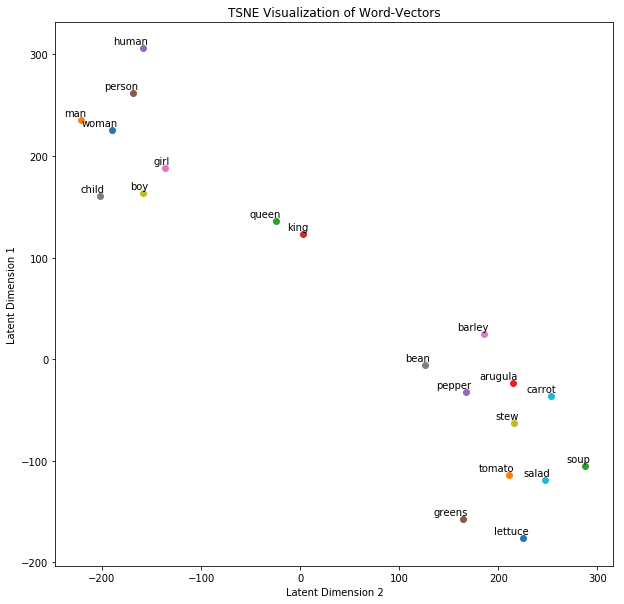

In [46]:
tsne_plot(my_word_list, my_word_vectors, 3000, 23,  "TSNE Visualization of Word-Vectors") #don't use too many words, won't finish running

Try visualizing the most feminine and most masculine words:

In [47]:
my_word_list=[]
my_word_vectors=[]
label=[]

for i in currentmodel.wv.most_similar(positive=['woman'], negative=['man'], topn=30):   #30 most feminine words
    if my_word_list not in my_word_list:
        my_word_list.append(i[0])
        my_word_vectors.append(currentmodel.wv[i[0]])
        label.append('fem')

for i in currentmodel.wv.most_similar(positive=['man'], negative=['woman'], topn=30):   #30 most masculine words
    if my_word_list not in my_word_list:
        my_word_list.append(i[0])
        my_word_vectors.append(currentmodel.wv[i[0]])
        label.append('masc')

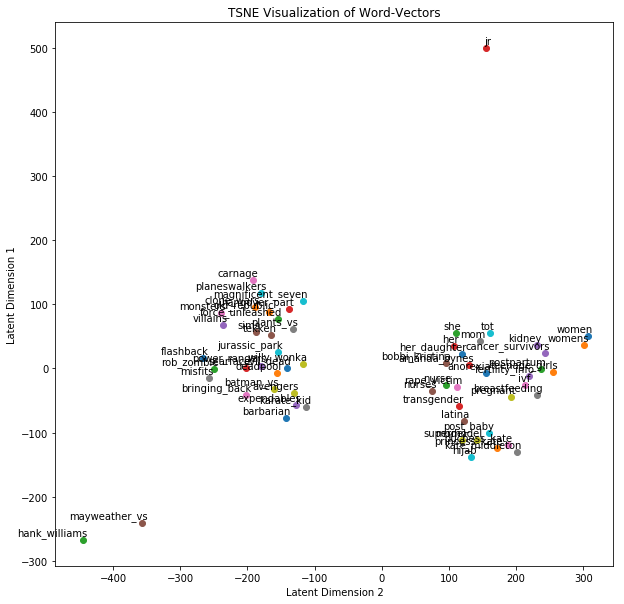

In [48]:
tsne_plot(my_word_list, my_word_vectors, 3000, 23,  "TSNE Visualization of Word-Vectors") #don't use too many words, won't finish running

If your plot doesn't look meaningful, want to see how robust the patterns are, or you want to understand TSNE better, try tuning parameters (especially the perplexity) and take a look at this great [article](https://distill.pub/2016/misread-tsne/).